In [1]:
import pandas as pd
from pathlib import Path

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression # Cambiado por clasificación
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.pipeline import Pipeline

In [3]:
ROOT = Path.cwd().parent
path_raw = ROOT / "data" / "processed" / "heart_clean.csv"
df = pd.read_csv(path_raw)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
import sys
root = Path.cwd().parent
if str(root) not in sys.path:
    sys.path.append(str(root))

In [5]:
from src.models import baseline
from src.models import randomforest_basemodel
from src.models import svc_basemodel
from src.models import decisiontree_basemodel
from src.models import xgboost_basemodel

In [6]:
from src.models import baseline
# Just using a simple train test split and a baseline model as Logistic Regresion with default parameters
baseline(df, "HeartDisease")

Confusion Matrix:
[[98 13]
 [15 98]]
Score in Training set: 0.8601532567049809
Score in Test set: 0.875

--- Informe de Clasificación (Test Set) ---
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       111
           1       0.88      0.87      0.88       113

    accuracy                           0.88       224
   macro avg       0.88      0.88      0.88       224
weighted avg       0.88      0.88      0.88       224

ROC-AUC Score: 0.9380


In [7]:
randomforest_basemodel(df, "HeartDisease")

Confusion Matrix:
[[67  4]
 [ 9 70]]
Score in Training set: 1.0
Score in Test set: 0.9133333333333333

--- Informe de Clasificación (Test Set) ---
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        71
           1       0.95      0.89      0.92        79

    accuracy                           0.91       150
   macro avg       0.91      0.91      0.91       150
weighted avg       0.92      0.91      0.91       150

ROC-AUC Score: 0.9583


In [8]:
svc_basemodel(df, "HeartDisease")

Confusion Matrix:
[[66  5]
 [10 69]]
Score in Training set: 0.9010067114093959
Score in Test set: 0.9

--- Informe de Clasificación (Test Set) ---
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        71
           1       0.93      0.87      0.90        79

    accuracy                           0.90       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.90      0.90      0.90       150

ROC-AUC Score: 0.9551


In [9]:
decisiontree_basemodel(df, "HeartDisease")

Confusion Matrix:
[[64  7]
 [14 65]]
Score in Training set: 1.0
Score in Test set: 0.86

--- Informe de Clasificación (Test Set) ---
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        71
           1       0.90      0.82      0.86        79

    accuracy                           0.86       150
   macro avg       0.86      0.86      0.86       150
weighted avg       0.86      0.86      0.86       150

ROC-AUC Score: 0.8621


In [10]:
xgboost_basemodel(df, "HeartDisease")

Confusion Matrix:
[[67  4]
 [13 66]]
Score in Training set: 1.0
Score in Test set: 0.8866666666666667

--- Informe de Clasificación (Test Set) ---
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        71
           1       0.94      0.84      0.89        79

    accuracy                           0.89       150
   macro avg       0.89      0.89      0.89       150
weighted avg       0.89      0.89      0.89       150

ROC-AUC Score: 0.9472


### WE OBSERVED THAT THERE ARE THRE BASICS MODELS , CONSIDERING THAT THEY ARE CALCULATED EACH ONE DIFERENTLY, THERE IS NO CORRELATION .
WE ARE GOING TO USE A OPTUNA SEARCH TO DETERMINE THE BEST HIPER PARAMETERES , THEN CALCULATED 

In [20]:
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score # <--- Falta esta
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [80]:
def logistic_regression_optuna(df,target):
    X= df.drop(columns=[target])
    y= df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
    col_num=X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    col_cat=X.select_dtypes(include=['object', 'category']).columns.tolist()
    preprocessor=  ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), col_num),
            ('cat', OneHotEncoder(handle_unknown='ignore'), col_cat)
        ])
    
    def objective(trial):
        C= trial.suggest_float('C', 1e-5, 1e2, log=True)
        solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
        if solver == 'liblinear':
            penalty = trial.suggest_categorical('penalty_lib', ['l1', 'l2'])
        elif solver == 'saga':
            penalty = trial.suggest_categorical('penalty_saga', ['l1', 'l2', 'elasticnet', None])
        else: # lbfgs
            penalty = trial.suggest_categorical('penalty_lbfgs', ['l2', None])
        l1_ratio = None
        if penalty == 'elasticnet':
            l1_ratio = trial.suggest_float('l1_ratio', 0, 1)    
        
        model= LogisticRegression(
            C=C,
            solver=solver,
            penalty=penalty,
            l1_ratio=l1_ratio,
            max_iter=1000,
            random_state=42
        )
        pipe=Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc').mean()
        return score

    study= optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial), n_trials=100)
        

    best_model= LogisticRegression(
        C=study.best_params['C'],
        solver=study.best_params['solver'],
        penalty=study.best_params.get('penalty_lib') or study.best_params.get('penalty_saga') or study.best_params.get('penalty_lbfgs'),
        l1_ratio=study.best_params.get('l1_ratio', None),
        max_iter=1000,
        random_state=42 
    )
    best_pipe= Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])
    best_pipe.fit(X_train, y_train)

    y_pred= best_pipe.predict(X_test)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    y_proba= best_pipe.predict_proba(X_test)[:, 1]
    roc_auc= roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    print("score in training", best_pipe.score(X_train, y_train))
    print("score in testing", best_pipe.score(X_test, y_test))
    
    return study.best_params



In [47]:
logistic_regression_optuna(df, "HeartDisease")

[I 2025-12-23 17:38:52,977] A new study created in memory with name: no-name-73543e27-2c46-4172-af71-6cb8e5dc5084
C:\Users\APUESTAS\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\APUESTAS\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\APUESTAS\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\APUESTAS\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\APUESTAS\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logisti

Confusion Matrix:
[[67 11]
 [10 62]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86        78
           1       0.85      0.86      0.86        72

    accuracy                           0.86       150
   macro avg       0.86      0.86      0.86       150
weighted avg       0.86      0.86      0.86       150

ROC-AUC Score: 0.9225
score in training 0.8691275167785235
score in testing 0.86


{'C': 0.29045887470856185, 'solver': 'liblinear', 'penalty_lib': 'l1'}

In [84]:
def random_forest_optuna(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
    
    col_num = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    col_cat = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), col_num),
            ('cat', OneHotEncoder(handle_unknown='ignore'), col_cat)
        ])
    
    def objective(trial):
        n_estimators = trial.suggest_int('n_estimators', 5, 500)
        max_depth = trial.suggest_int('max_depth', 3, 30)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
        
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            criterion=criterion,
            random_state=42,
            n_jobs=-1
        )
        
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc').mean()
        return score

    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial), n_trials=20)

    best_model = RandomForestClassifier(
        n_estimators=study.best_params['n_estimators'],
        max_depth=study.best_params['max_depth'],
        min_samples_split=study.best_params['min_samples_split'],
        min_samples_leaf=study.best_params['min_samples_leaf'],
        max_features=study.best_params['max_features'],
        criterion=study.best_params['criterion'],
        random_state=42,
        n_jobs=-1
    )
    
    best_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])
    best_pipe.fit(X_train, y_train)

    y_pred = best_pipe.predict(X_test)
    y_proba = best_pipe.predict_proba(X_test)[:, 1]
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    
    print("score in training", best_pipe.score(X_train, y_train))
    print("score in testing", best_pipe.score(X_test, y_test))
    
    return study.best_params

In [55]:
random_forest_optuna(df, "HeartDisease")

[I 2025-12-23 17:46:37,505] A new study created in memory with name: no-name-934a863b-7b71-4bbe-8a4d-b10390da1307
[I 2025-12-23 17:46:39,912] Trial 0 finished with value: 0.9321992898272307 and parameters: {'n_estimators': 339, 'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.9321992898272307.
[I 2025-12-23 17:46:40,913] Trial 1 finished with value: 0.9318019831965987 and parameters: {'n_estimators': 135, 'max_depth': 28, 'min_samples_split': 18, 'min_samples_leaf': 8, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.9321992898272307.
[I 2025-12-23 17:46:43,593] Trial 2 finished with value: 0.9290973208751525 and parameters: {'n_estimators': 408, 'max_depth': 26, 'min_samples_split': 13, 'min_samples_leaf': 16, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 0 with value: 0.9321992898272307.
[I 2025-12-23 17:46:45,861] Trial 3 finished with value: 0.92882494

Confusion Matrix:
[[64 14]
 [ 8 64]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.85        78
           1       0.82      0.89      0.85        72

    accuracy                           0.85       150
   macro avg       0.85      0.85      0.85       150
weighted avg       0.86      0.85      0.85       150

ROC-AUC Score: 0.9382
score in training 0.9077181208053692
score in testing 0.8533333333333334


{'n_estimators': 358,
 'max_depth': 23,
 'min_samples_split': 16,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'criterion': 'entropy'}

In [85]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

def svc_optuna(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
    
    col_num = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    col_cat = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), col_num),
            ('cat', OneHotEncoder(handle_unknown='ignore'), col_cat)
        ])
    
    def objective(trial):
        C = trial.suggest_float('C', 1e-3, 1e3, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
        
        model = SVC(
            C=C,
            kernel=kernel,
            gamma=gamma,
            probability=True,
            random_state=42
        )
        
        pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
        score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc').mean()
        return score

    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial), n_trials=50)

    best_model = SVC(
        C=study.best_params['C'],
        kernel=study.best_params['kernel'],
        gamma=study.best_params['gamma'],
        probability=True,
        random_state=42
    )
    
    best_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])
    best_pipe.fit(X_train, y_train)

    y_pred = best_pipe.predict(X_test)
    y_proba = best_pipe.predict_proba(X_test)[:, 1]
    
    print("--- SVC OPTIMIZADO ---")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print("score in training", best_pipe.score(X_train, y_train))
    print("score in testing", best_pipe.score(X_test, y_test))
    
    return study.best_params

In [57]:
svc_optuna(df, "HeartDisease")

[I 2025-12-23 21:15:22,630] A new study created in memory with name: no-name-92ebfd46-fc97-44ef-b580-447c445d1a08
[I 2025-12-23 21:15:22,909] Trial 0 finished with value: 0.9193972514491554 and parameters: {'C': 0.6277402379423255, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.9193972514491554.
[I 2025-12-23 21:15:23,059] Trial 1 finished with value: 0.8337254105566014 and parameters: {'C': 54.653013212662174, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 0 with value: 0.9193972514491554.
[I 2025-12-23 21:15:23,247] Trial 2 finished with value: 0.899053733925187 and parameters: {'C': 36.90103196186415, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.9193972514491554.
[I 2025-12-23 21:15:23,432] Trial 3 finished with value: 0.9210207739009582 and parameters: {'C': 0.8724655790443231, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 3 with value: 0.9210207739009582.
[I 2025-12-23 21:15:23,788] Trial 4 finished with value: 0.906673782510552 

--- SVC OPTIMIZADO ---
[[65 13]
 [10 62]]
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        78
           1       0.83      0.86      0.84        72

    accuracy                           0.85       150
   macro avg       0.85      0.85      0.85       150
weighted avg       0.85      0.85      0.85       150

ROC-AUC Score: 0.9183


{'C': 0.08832432287624255, 'kernel': 'linear', 'gamma': 'scale'}

In [86]:
params_finales_lr = logistic_regression_optuna(df, "HeartDisease")
params_finales_rf = random_forest_optuna(df, "HeartDisease")
params_finales_svc = svc_optuna(df, "HeartDisease")

[I 2025-12-23 21:40:15,095] A new study created in memory with name: no-name-84f44cf2-9a3c-415b-bff5-482896d5d32d
[I 2025-12-23 21:40:15,714] Trial 0 finished with value: 0.9222547786720323 and parameters: {'C': 4.494250614730379, 'solver': 'saga', 'penalty_saga': 'elasticnet', 'l1_ratio': 0.45882931724670584}. Best is trial 0 with value: 0.9222547786720323.
[I 2025-12-23 21:40:15,790] Trial 1 finished with value: 0.8992593058350099 and parameters: {'C': 0.00046594335409821377, 'solver': 'liblinear', 'penalty_lib': 'l2'}. Best is trial 0 with value: 0.9222547786720323.
[I 2025-12-23 21:40:15,872] Trial 2 finished with value: 0.8981922786720322 and parameters: {'C': 1.7455005376426353e-05, 'solver': 'saga', 'penalty_saga': 'l2'}. Best is trial 0 with value: 0.9222547786720323.
C:\Users\APUESTAS\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\APUEST

Confusion Matrix:
[[34  5]
 [ 2 34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91        39
           1       0.87      0.94      0.91        36

    accuracy                           0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75

ROC-AUC Score: 0.9537
score in training 0.8688524590163934
score in testing 0.9066666666666666


[I 2025-12-23 21:40:26,256] Trial 0 finished with value: 0.9156356891348088 and parameters: {'n_estimators': 154, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None, 'criterion': 'gini'}. Best is trial 0 with value: 0.9156356891348088.
[I 2025-12-23 21:40:27,889] Trial 1 finished with value: 0.9280633802816901 and parameters: {'n_estimators': 212, 'max_depth': 27, 'min_samples_split': 19, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 1 with value: 0.9280633802816901.
[I 2025-12-23 21:40:29,489] Trial 2 finished with value: 0.9191118586519114 and parameters: {'n_estimators': 205, 'max_depth': 25, 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_features': None, 'criterion': 'gini'}. Best is trial 1 with value: 0.9280633802816901.
[I 2025-12-23 21:40:32,258] Trial 3 finished with value: 0.9296730382293761 and parameters: {'n_estimators': 378, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_f

Confusion Matrix:
[[34  5]
 [ 2 34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.91        39
           1       0.87      0.94      0.91        36

    accuracy                           0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75

ROC-AUC Score: 0.9601
score in training 0.9031296572280179
score in testing 0.9066666666666666


[I 2025-12-23 21:41:10,789] Trial 0 finished with value: 0.9225710513078471 and parameters: {'C': 1.1730686120982512, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.9225710513078471.
[I 2025-12-23 21:41:11,078] Trial 1 finished with value: 0.8969944668008047 and parameters: {'C': 0.005034375566273604, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 0 with value: 0.9225710513078471.
[I 2025-12-23 21:41:11,376] Trial 2 finished with value: 0.9084840291750502 and parameters: {'C': 5.548779365971086, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.9225710513078471.
[I 2025-12-23 21:41:11,577] Trial 3 finished with value: 0.9152357897384306 and parameters: {'C': 0.003272938132454389, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.9225710513078471.
[I 2025-12-23 21:41:11,923] Trial 4 finished with value: 0.8735965794768612 and parameters: {'C': 380.7464143721494, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.

--- SVC OPTIMIZADO ---
[[34  5]
 [ 2 34]]
              precision    recall  f1-score   support

           0       0.94      0.87      0.91        39
           1       0.87      0.94      0.91        36

    accuracy                           0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75

ROC-AUC Score: 0.9459
score in training 0.8628912071535022
score in testing 0.9066666666666666


In [87]:
from sklearn.ensemble import StackingClassifier

def create_triple_stacking(df, target, params_lr, params_rf, params_svc):
    X = df.drop(columns=[target])
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
    
    col_num = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    col_cat = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), col_num),
            ('cat', OneHotEncoder(handle_unknown='ignore'), col_cat)
        ])

    penalty_lr = params_lr.get('penalty_lib') or params_lr.get('penalty_saga') or params_lr.get('penalty_lbfgs')
    
    model_lr = LogisticRegression(
        C=params_lr['C'],
        solver=params_lr['solver'],
        penalty=penalty_lr,
        l1_ratio=params_lr.get('l1_ratio'),
        max_iter=2000,
        random_state=42
    )
    
    model_rf = RandomForestClassifier(
        n_estimators=params_rf['n_estimators'],
        max_depth=params_rf['max_depth'],
        min_samples_split=params_rf['min_samples_split'],
        min_samples_leaf=params_rf['min_samples_leaf'],
        max_features=params_rf['max_features'],
        criterion=params_rf['criterion'],
        random_state=42,
        n_jobs=-1
    )

    model_svc = SVC(
        C=params_svc['C'],
        kernel=params_svc['kernel'],
        gamma=params_svc['gamma'],
        probability=True,
        random_state=42
    )

    base_models = [
        ('lr', Pipeline(steps=[('preprocessor', preprocessor), ('model', model_lr)])),
        ('rf', Pipeline(steps=[('preprocessor', preprocessor), ('model', model_rf)])),
        ('svc', Pipeline(steps=[('preprocessor', preprocessor), ('model', model_svc)]))
    ]

    stacking_model = StackingClassifier(
        estimators=base_models,
        final_estimator=LogisticRegression(),
        cv=5,
        stack_method='predict_proba'
    )

    stacking_model.fit(X_train, y_train)

    y_pred = stacking_model.predict(X_test)
    y_proba = stacking_model.predict_proba(X_test)[:, 1]

    print("\n--- RESULTADOS DEL ENSAMBLE TRIPLE ---")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Score in testing: {stacking_model.score(X_test, y_test):.4f}")
    print(f"Score in training: {stacking_model.score(X_train, y_train):.4f}")

    return stacking_model

In [88]:
# Llamas a la función de Stacking usando los resultados anteriores
modelo_ensamble_final = create_triple_stacking(
    df=df, 
    target="HeartDisease", 
    params_lr=params_finales_lr, 
    params_rf=params_finales_rf, 
    params_svc=params_finales_svc
)


--- RESULTADOS DEL ENSAMBLE TRIPLE ---
[[34  5]
 [ 2 34]]
              precision    recall  f1-score   support

           0       0.94      0.87      0.91        39
           1       0.87      0.94      0.91        36

    accuracy                           0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.91      0.91      0.91        75

ROC-AUC Score: 0.9573
Score in testing: 0.9067
Score in training: 0.8882


In [94]:
import joblib

In [95]:
joblib.dump(modelo_ensamble_final, 'modelo_heart_disease_stacking.pkl')

print("\n✅ ¡Modelo guardado con éxito!")
print("Archivo generado: modelo_heart_disease_stacking.pkl")


✅ ¡Modelo guardado con éxito!
Archivo generado: modelo_heart_disease_stacking.pkl


In [90]:
def plot_ensemble_importance(model, X_test, y_test):
    # Calculamos la importancia por permutación
    results = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='roc_auc')
    
    # Organizamos los datos
    feature_importance = pd.Series(results.importances_mean, index=X_test.columns)
    feature_importance = feature_importance.sort_values(ascending=True)

    # Graficamos
    plt.figure(figsize=(10, 6))
    feature_importance.plot(kind='barh', color='skyblue')
    plt.title('Importancia de Variables: Ensamble Triple (0.95 AUC)')
    plt.xlabel('Caída en ROC-AUC al desordenar la variable')
    plt.show()

# Uso:
# plot_ensemble_importance(mejor_modelo_ensamble, X_test, y_test)

In [76]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

In [77]:
X = df.drop(columns=["HeartDisease"])
y = df["HeartDisease"]

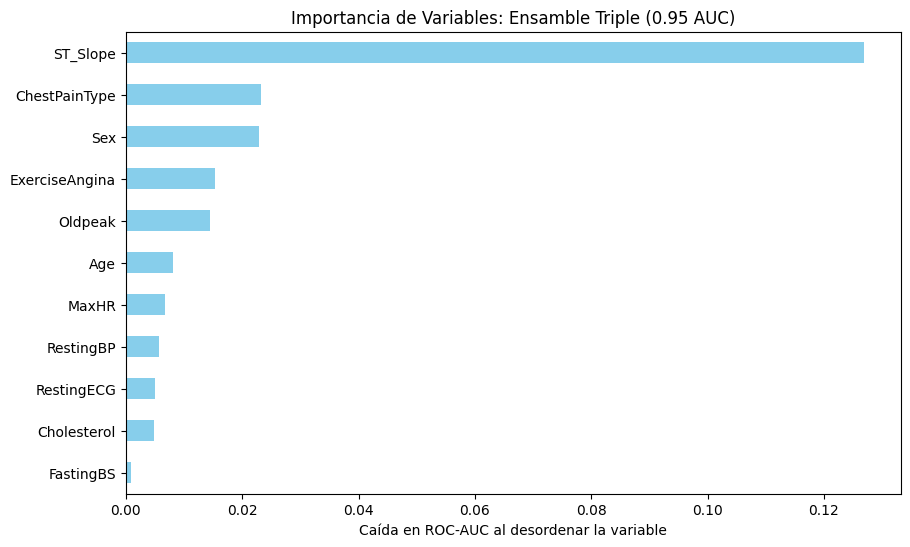

In [91]:
plot_ensemble_importance(modelo_ensamble_final, X,y)

In [ ]:
import joblib

# 1. Llamamos a tu función y guardamos el objeto retornado en una variable
modelo_ensamble_final = create_triple_stacking(
    df, 
    "HeartDisease", 
    params_lr, 
    params_rf, 
    params_svc
)

# 2. Guardamos físicamente el modelo en tu computadora
# El nombre del archivo debe coincidir con el que pusimos en la app de Streamlit
joblib.dump(modelo_ensamble_final, 'modelo_heart_disease_stacking.pkl')

print("\n✅ ¡Modelo guardado con éxito!")
print("Archivo generado: modelo_heart_disease_stacking.pkl")

In [68]:
def logistic_regression_adjusted_basemodel(df,target):
    # 1. Dividir los datos en características (X) y objetivo (y)
    X = df.drop(columns=[target])
    y = df[target]
    
    # 2. Dividir en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    # 3. Preprocesamiento: Escalado y codificación
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
    
    # 4. Crear el pipeline con LogisticRegression
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='liblinear', random_state=42))
    ])
    
    param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100], # Fuerza de regularización (menor C = más regularización)
    'classifier__penalty': ['l1', 'l2'],             # Tipo de penalización (Lasso o Ridge)
    'classifier__max_iter': [100, 200, 500]          # Iteraciones para converger
    }

    # 3. Configurar el GridSearchCV
    # Usamos StratifiedKFold para mantener la proporción de clases en cada fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv,
        scoring='roc_auc', # Puedes cambiarlo por 'f1' o 'accuracy'
        n_jobs=-1,         # Usa todos los núcleos de tu CPU
        verbose=1
    )

    # 4. Entrenar
    grid_search.fit(X_train, y_train)

    # 5. Ver mejores resultados
    print(f"Mejor Score (AUC): {grid_search.best_score_:.4f}")
    print(f"Mejores Parámetros: {grid_search.best_params_}")
    # --- NUEVA SECCIÓN: EXTRAER RESULTADOS POR FOLD ---
    
    # 1. Obtener el índice de la mejor combinación
    best_index = grid_search.best_index_
    
    print("\n" + "="*30)
    print("RESULTADOS POR FOLD (Mejor Modelo)")
    print("="*30)
    
    # 2. Iterar sobre los resultados de los folds para ese índice
    for i in range(cv.n_splits):
        fold_score = grid_search.cv_results_[f'split{i}_test_score'][best_index]
        print(f"Fold {i+1}: AUC = {fold_score:.4f}")
    
    print("-" * 30)
    print(f"Mejor Score Promedio (AUC): {grid_search.best_score_:.4f}")
    print(f"Mejores Parámetros: {grid_search.best_params_}")

    print("Score in Training:", grid_search.best_estimator_.score(X_train, y_train))
    print("Score in Testing:", grid_search.best_estimator_.score(X_test, y_test))
    import numpy as np
    import matplotlib.pyplot as plt

    # 1. Obtener los nombres de las columnas después de la transformación
    # Extraemos los nombres de las categorías del OneHotEncoder
    cat_encoder = grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat']
    cat_features_transformed = cat_encoder.get_feature_names_out(categorical_features)

    # Combinamos nombres numéricos y categóricos transformados
    all_features = np.concatenate([numeric_features, cat_features_transformed])

    # 2. Extraer los coeficientes del mejor modelo
    coefficients = grid_search.best_estimator_.named_steps['classifier'].coef_[0]

    # 3. Crear un DataFrame para visualizar mejor
    feature_importance = pd.DataFrame({
        'Feature': all_features,
        'Coefficient': coefficients
    })

    # Añadimos el valor absoluto para ordenar por importancia real (positiva o negativa)
    feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
    feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

    # 4. Graficar
    plt.figure(figsize=(10, 8))
    colors = ['red' if c > 0 else 'blue' for c in feature_importance['Coefficient']]
    plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
    plt.xlabel("Valor del Coeficiente (Peso)")
    plt.title("Importancia de las Variables (Modelo Logistic Regression L1)")
    plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
    plt.grid(axis='x', alpha=0.3)
    plt.show()

    

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejor Score (AUC): 0.9190
Mejores Parámetros: {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1'}

RESULTADOS POR FOLD (Mejor Modelo)
Fold 1: AUC = 0.9393
Fold 2: AUC = 0.8960
Fold 3: AUC = 0.9394
Fold 4: AUC = 0.9150
Fold 5: AUC = 0.9054
------------------------------
Mejor Score Promedio (AUC): 0.9190
Mejores Parámetros: {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1'}
Score in Training: 0.8643815201192251
Score in Testing: 0.8666666666666667


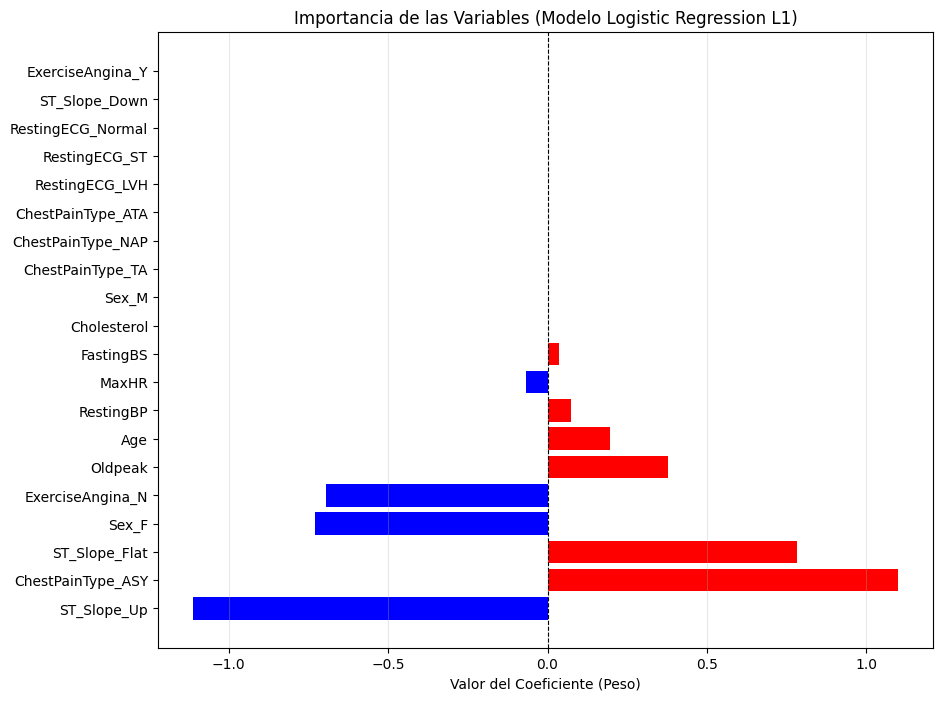

In [69]:
logistic_regression_adjusted_basemodel(df,"HeartDisease")

In [ ]:

import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def objective(trial, X, y):
    # 1. Definir el espacio de búsqueda de hiperparámetros
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # 2. Configurar el preprocesamiento (usando tu lógica anterior)
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object', 'category']).columns
    
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    # 3. Crear el pipeline con los parámetros sugeridos por Optuna
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    # 4. Usar validación cruzada para evaluar la robustez del modelo
    # Optuna buscará maximizar el promedio del ROC-AUC
    score = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc').mean()
    
    return score

def run_optuna_optimization(df, target):
    X = df.drop(columns=[target])
    y = df[target]

    # Crear el estudio de Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

    print("\n--- Optimización Finalizada ---")
    print(f"Mejor valor (ROC-AUC): {study.best_value:.4f}")
    print("Mejores parámetros:", study.best_params)
    
    return study.best_params

Writing app.py


In [99]:
%%writefile app.py
import streamlit as st
import joblib
import pandas as pd
import numpy as np

# Configuración de la página
st.set_page_config(page_title="Asistente de Diagnóstico Cardíaco", layout="centered")

# 1. Cargar el modelo guardado
@st.cache_resource
def load_model():
    return joblib.load('modelo_heart_disease_stacking.pkl')

model = load_model()

st.title("🏥 Sistema de Predicción de Riesgo Cardíaco")
st.write("Ingrese los datos clínicos del paciente para evaluar el riesgo de enfermedad coronaria.")

# 2. Crear la interfaz de usuario (Inputs)
st.sidebar.header("Datos del Paciente")

col1, col2 = st.columns(2)

with col1:
    age = st.slider("Edad", 20, 90, 50)
    sex = st.selectbox("Sexo", ["M", "F"])
    cp = st.selectbox("Tipo de Dolor de Pecho", ["ATA", "NAP", "ASY", "TA"])
    trestbps = st.slider("Presión Arterial en Reposo (mm Hg)", 80, 200, 120)
    chol = st.slider("Colesterol Sérico (mm/dl)", 100, 600, 200)

with col2:
    fbs = st.radio("Azúcar en sangre en ayunas > 120 mg/dl", [1, 0])
    restecg = st.selectbox("Electrocardiograma en Reposo", ["Normal", "ST", "LVH"])
    thalach = st.slider("Frecuencia Cardíaca Máxima", 60, 210, 150)
    exang = st.radio("Angina inducida por ejercicio", ["Y", "N"])
    oldpeak = st.slider("Depresión del ST (Oldpeak)", 0.0, 6.0, 1.0, 0.1)
    slope = st.selectbox("Pendiente del Segmento ST", ["Up", "Flat", "Down"])

# 3. Procesar los datos ingresados
input_data = {
    'Age': age, 'Sex': sex, 'ChestPainType': cp, 'RestingBP': trestbps,
    'Cholesterol': chol, 'FastingBS': fbs, 'RestingECG': restecg,
    'MaxHR': thalach, 'ExerciseAngina': exang, 'Oldpeak': oldpeak, 'ST_Slope': slope
}

# 4. Botón de Predicción
if st.button("Analizar Riesgo"):
    df_input = pd.DataFrame([input_data])
    
    # Obtener probabilidad del modelo
    prob = model.predict_proba(df_input)[0][1]
    
    st.divider()
    
    # Mostrar resultados
    if prob > 0.5:
        st.error(f"### RIESGO ALTO DETECTADO")
        st.write(f"La probabilidad estimada de enfermedad cardíaca es del **{prob*100:.2f}%**.")
    else:
        st.success(f"### RIESGO BAJO")
        st.write(f"La probabilidad estimada de enfermedad cardíaca es del **{prob*100:.2f}%**.")

    st.info("Nota: Este sistema es una herramienta de apoyo basada en datos y no sustituye un diagnóstico médico profesional.")

Overwriting app.py
